<a href="https://colab.research.google.com/github/DaniloRiver/Seminario-de-Investigacion-UNAH/blob/main/Modelo_de_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Seminario de** **Investigación:** Regresión Logística



# Preliminares

In [95]:
#Librerias a Utilizar

#!pip install imbalanced-learn
#!pip install delayed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import (cross_val_score,cross_val_predict,KFold)

from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter





In [7]:
# scikit-learn version
import sys
import sklearn
print('sklearn: %s' % sklearn.__version__)
print(sys.version)
import warnings
warnings.filterwarnings("ignore")

sklearn: 0.22.2.post1
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [94]:
# Cargando el Dataset Diabetes
url="https://raw.githubusercontent.com/DaniloRiver/Seminario-de-Investigacion-UNAH/main/diabetes.csv"
datos= pd.read_csv(url)
datos.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Análisis Exploratorio

In [14]:
#Estadisticos para el Dataset
datos.describe()
Diabetes= datos

In [15]:
# Utilizando los primeros 200 registros de Diabetes.csv (Dimensiones)
#Diabetes=datos[:200]
Diabetes.shape

(768, 9)

In [16]:
# Utilizando los registros de Diabetes.csv (Dimensiones)
Diabetes=datos
print(Diabetes.shape)
print(pd.value_counts(Diabetes['Outcome'], sort = True))

(768, 9)
0    500
1    268
Name: Outcome, dtype: int64


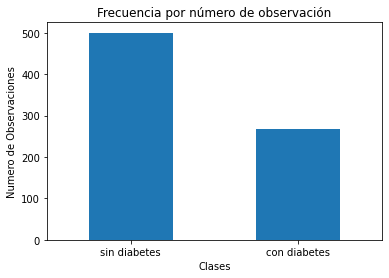

In [57]:
#Recuento de Clases
conteo_clases = pd.value_counts(Diabetes['Outcome'], sort = True)
conteo_clases.plot(kind = 'bar', rot=0)
plt.title("Frecuencia por número de observación")
plt.xlabel("Clases")
plt.ylabel("Numero de Observaciones")
plt.xticks(range(2),['sin diabetes','con diabetes'])
plt.savefig('explorar.eps',format='eps',dpi=1200,transparent=True)

In [18]:
#sns.pairplot(Diabetes)
#plt.tight_layout()

# Determinación de los Parametros Optimos para el Modelo

In [96]:
#Funcion que Calcula la metrica AUC para cada parametro dentro del dataset
def calcular_auc(variables, target, tabla_base):
    X=tabla_base[variables]
    y=tabla_base[target]
    logreg = LogisticRegression()
    logreg.fit(X, y)
    predictor = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictor)
    return(auc)


In [97]:
#Funcion que determina la mejor combinacion y cantidad de parametros a utilizar mediante Forward stepwise 
def next_best(variables_actuales,variables_candidatos, target, tabla_base):
    best_auc = -1
    best_variable = None
    for v in variables_candidatos:
        auc_v = calcular_auc(variables_actuales + [v], target, tabla_base)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable


In [98]:
#Se utilizaran 6 de las 8 variables dentro del dataset con mejor AUC entre ellas
variables_candidatos = ['Pregnancies','Glucose','SkinThickness','BloodPressure','DiabetesPedigreeFunction','Age','BMI']
variables_actuales = []
target = "Outcome"
maximo_numero_variables = 6
numero_iteraciones = min(maximo_numero_variables, len(variables_candidatos))
for i in range(0,numero_iteraciones):
    next_var = next_best(variables_actuales,variables_candidatos,target,Diabetes)
    variables_actuales = variables_actuales + [next_var]
    variables_candidatos.remove(next_var)
print(variables_actuales)

['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'BloodPressure', 'Age']


In [99]:
#Interpretacion de cada variable y su probabilidad AUC respectiva
auc_valor = []
variables_evaluadas = []
for v in variables_actuales:
    variables_evaluadas.append(v)
    auc_valores = calcular_auc(variables_evaluadas, "Outcome", Diabetes)
    auc_valor.append(auc_valores)

for p,c in zip(variables_evaluadas,list(auc_valor)):
    print(p + '\t\t' + str(round(c,2)))



Glucose		0.79
BMI		0.81
Pregnancies		0.83
DiabetesPedigreeFunction		0.83
BloodPressure		0.84
Age		0.84


# División y Entrenamiento de los Datos

In [100]:
# Preparando las variables X, y del modelo  X=Matriz de Predictores , y= variable de resultados  1: con diabetes , 0: sin diabetes
X=Diabetes[variables_evaluadas]
y=Diabetes.Outcome

In [101]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= 0.25,random_state=0)

In [102]:
#  StandardScaler() normalizará las características (cada columna de X, INDIVIDUALMENTE !!!) 
#  para que cada columna/característica/variable tenga mean = 0 y standard deviation = 1.

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

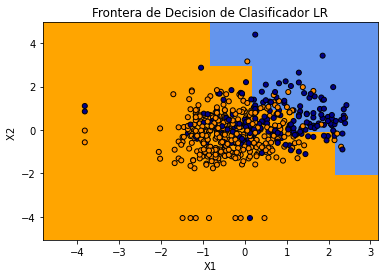

In [103]:
#Frontera de Decision usando los primeros dos atributos
from matplotlib.colors import ListedColormap
h=1
X=X_train[:,0:2]
y=y_train

# Crear mapas de colores
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['Glucose']:
    # creamos una instancia del clasificador de RL
    clf =LogisticRegression()
    clf.fit(X, y)

    #Graficamos la frontera de decision. Para ello se asigna un color a cada punto
    # en la cuadricula [x_min, x_max]x[y_min, y_max].

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

 # Pon el resultado en una gráfica de color
    Z = Z.reshape(xx.shape)
    plt.figure()

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light )

# Trazar también los puntos de entrenamiento
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=25)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('X1')
    plt.ylabel('X2 ')
    plt.title( 'Frontera de Decision de Clasificador LR'  )
    plt.savefig('explorar.eps',format='eps')
plt.show()

#Modelo con Parametros Modificados

In [104]:
# Aplicacion del algoritmo de regresion logistica y entrenamiento de las variables X_train,y_train

logreg =LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# coeficiente que corresponde a los coeficientes B (beta) que corresponden a los de la ecuacion de regresion logistica (pesos)
logreg.coef_


array([[ 0.98986246,  0.71087103,  0.29835728,  0.28849499, -0.19179062,
         0.26128227]])

In [106]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[117  13]
 [ 26  36]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       130
           1       0.73      0.58      0.65        62

    accuracy                           0.80       192
   macro avg       0.78      0.74      0.75       192
weighted avg       0.79      0.80      0.79       192



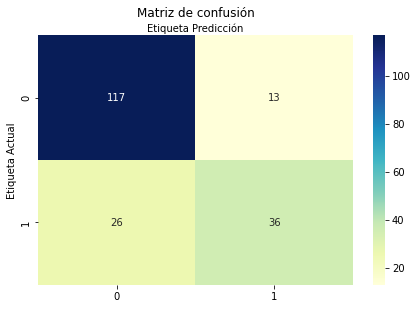

In [107]:
#Mapa de calor de la Matriz de confusion
def confusion(Matriz_confusion):
    nombre_clase=[0,1]
    fig,ax= plt.subplots()
    tick_marks=np.arange(len(nombre_clase))
    plt.xticks(tick_marks,nombre_clase)
    plt.yticks(tick_marks,nombre_clase)

    sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title("Matriz de confusión",y=1.1)
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicción')
    plt.savefig('confusion1.eps',format='eps',dpi=1200)
confusion(Matriz_confusion)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


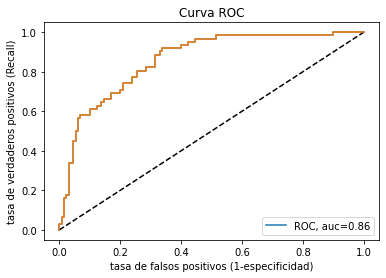

In [108]:
#Lo que estamos viendo es exactamente la curva ROC del clasificador. Y nos da bastante información: en primer lugar nos dice que aumentando o disminuyendo lo suficiente 
#el threshold podemos conseguir que nuestro algoritmo de clasificación alcance un TPR o un FPR casi perfecto.
#Cuando AUC es 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa. Esta es la peor situación.
#Cuando el AUC es aproximadamente 0.5, el modelo no tiene capacidad de discriminación para distinguir entre clase positiva y clase negativa.

y_pred_prob= logreg.predict_proba(X_test)[:,1]
fpr_1, tpr_1,tresholds1= roc_curve(y_test,y_pred_prob)
auc_score_1 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_1,tpr_1,label="ROC, auc="+str(round(auc_score_1,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr_1,tpr_1,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
plt.savefig('roc1.eps',format='eps', dpi=1200,transparent=True)
plt.show()

Regresión Logística: f1=0.649 auc=0.715


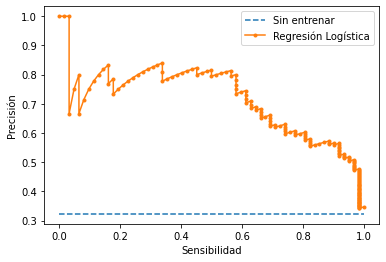

In [109]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predecimos probabilidades
y_pred_prob= logreg.predict_proba(X_test)[:,1]
# Sacamos los valores
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# Resumimos 
print('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# trazar las curvas de recuperación de precisión
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
#Etiquetas de ejes
pyplot.xlabel('Sensibilidad')
pyplot.ylabel('Precisión')
plt.savefig('recall.eps',format='eps', dpi=1200,transparent=True)
pyplot.legend()
pyplot.show()




# Estrategias Para Validación y Remuestreo de los Datos (Disminuir el desbalanceo)

**Estrategia: Penalización para compensar**

In [37]:
# Aplicacion del algoritmo de regresion logistica y entrenamiento de las variables X_train,y_train

logreg_1 =LogisticRegression(class_weight='balanced')
logreg_1.fit(X_train,y_train)
y_pred_0=logreg_1.predict(X_test)
y_pred_prob_1= logreg_1.predict_proba(X_test)[:,1]
fpr_2, tpr_2,tresholds2= roc_curve(y_test,y_pred_prob_1)
auc_score_2 = roc_auc_score(y_test, y_pred_prob_1)

#Matriz de confusion 
Matriz_confusion_0= confusion_matrix(y_test,y_pred_0)
print(Matriz_confusion_0)
print(classification_report(y_test,y_pred_0))

[[104  26]
 [ 17  45]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       130
           1       0.63      0.73      0.68        62

    accuracy                           0.78       192
   macro avg       0.75      0.76      0.75       192
weighted avg       0.79      0.78      0.78       192



**Estrategia: Subsampling en la clase mayoritaria**

In [38]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print("Distribución antes del remuestreo {}".format(Counter(y_train)))
print("Distribución después del remuestreo{}".format(Counter(y_train_res)))

modelo1=LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
modelo1.fit(X_train_res, y_train_res)
y_pred_1 = modelo1.predict(X_test)
y_pred_prob_2= modelo1.predict_proba(X_test)[:,1]
fpr_3, tpr_3,tresholds3= roc_curve(y_test,y_pred_prob_2)
auc_score_3 = roc_auc_score(y_test, y_pred_prob_2)

#Matriz de confusion
Matriz_confusion_1= confusion_matrix(y_test,y_pred_1)
print(Matriz_confusion_1)
print(classification_report(y_test,y_pred_1))


Distribución antes del remuestreo Counter({0: 370, 1: 206})
Distribución después del remuestreoCounter({0: 206, 1: 206})
[[100  30]
 [ 19  43]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       130
           1       0.59      0.69      0.64        62

    accuracy                           0.74       192
   macro avg       0.71      0.73      0.72       192
weighted avg       0.76      0.74      0.75       192



**Estrategia: Ensamble de Modelos con Balanceo**

In [39]:
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred_2 = bbc.predict(X_test)
y_pred_prob_3= bbc.predict_proba(X_test)[:,1]
fpr_4, tpr_4,tresholds4= roc_curve(y_test,y_pred_prob_3)
auc_score_4 = roc_auc_score(y_test, y_pred_prob_3)
Matriz_confusion_2= confusion_matrix(y_test,y_pred_2)
print(Matriz_confusion_2)
print(classification_report(y_test,y_pred_2))

[[104  26]
 [ 17  45]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       130
           1       0.63      0.73      0.68        62

    accuracy                           0.78       192
   macro avg       0.75      0.76      0.75       192
weighted avg       0.79      0.78      0.78       192



**Estrategia: Metodo UnderSampling**

In [40]:
os = RandomUnderSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution labels after resampling {}".format(Counter(y_train_res)))
modelo2=LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
modelo2.fit(X_train_res, y_train_res)
y_pred_3 = modelo2.predict(X_test)
y_pred_prob_4= modelo2.predict_proba(X_test)[:,1]
fpr_5, tpr_5,tresholds5= roc_curve(y_test,y_pred_prob_4)
auc_score_5 = roc_auc_score(y_test, y_pred_prob_4)
Matriz_confusion_3= confusion_matrix(y_test,y_pred_3)
print(Matriz_confusion_3)
print(classification_report(y_test,y_pred_3))


Distribution before resampling Counter({0: 370, 1: 206})
Distribution labels after resampling Counter({0: 206, 1: 206})
[[102  28]
 [ 18  44]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       130
           1       0.61      0.71      0.66        62

    accuracy                           0.76       192
   macro avg       0.73      0.75      0.74       192
weighted avg       0.77      0.76      0.76       192



**Estrategia: Oversampling de la clase minoritaria**

In [41]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

modelo3=LogisticRegression(C=1.0,penalty='l2',random_state=0)
modelo3.fit(X_train_res, y_train_res)
y_pred_4 = modelo3.predict(X_test)
y_pred_prob_5= modelo3.predict_proba(X_test)[:,1]
fpr_6, tpr_6,tresholds6= roc_curve(y_test,y_pred_prob_5)
auc_score_6 = roc_auc_score(y_test, y_pred_prob_5)
Matriz_confusion_4= confusion_matrix(y_test,y_pred_4)
print(Matriz_confusion_4)
print(classification_report(y_test,y_pred_4))

Distribution before resampling Counter({0: 370, 1: 206})
Distribution labels after resampling Counter({0: 370, 1: 370})
[[104  26]
 [ 14  48]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       130
           1       0.65      0.77      0.71        62

    accuracy                           0.79       192
   macro avg       0.77      0.79      0.77       192
weighted avg       0.81      0.79      0.80       192



**Estrategia: implementar K-Folds**

In [42]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
#for train,test in kf.split(Diabetes):
 # print(train)
  #print(test)


In [43]:
#modelox=LogisticRegression()
#modelox.fit(X,y)
y_pred_6= cross_val_predict(logreg,X,y,cv=kf,n_jobs=-1)
y_pred_prob_7= logreg.predict_proba(X_test)[:,1]
fpr_8, tpr_8,tresholds8= roc_curve(y_test,y_pred_prob_7)
auc_score_8 = roc_auc_score(y_test, y_pred_prob_7)
Matriz_confusion_6= confusion_matrix(y,y_pred_6)
print(Matriz_confusion_6)
print(classification_report(y,y_pred_6))

[[329  41]
 [ 97 109]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       370
           1       0.73      0.53      0.61       206

    accuracy                           0.76       576
   macro avg       0.75      0.71      0.72       576
weighted avg       0.76      0.76      0.75       576



#Representando las Estrategias en la Curva ROC

In [110]:
Estrategia =['Modelo -Parametros Modificados-','Penalización para compensar','Subsampling clase mayoritaria','Ensamble de Modelos con Balanceo','UnderSampling aleatorio',' Oversampling clase minoritaria',' implementar K-Folds']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


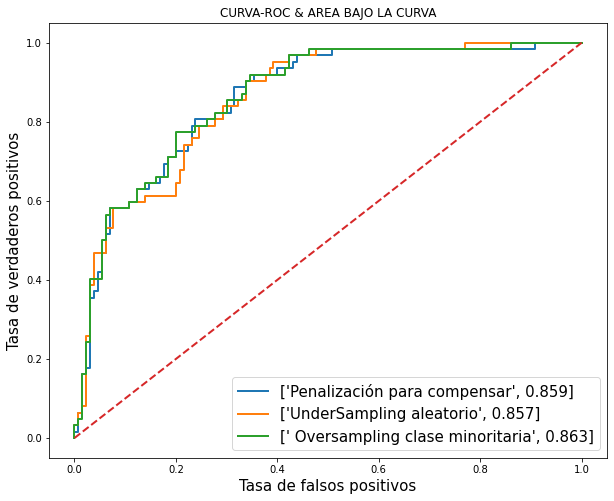

In [111]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
    
#ax.plot(fpr_1,tpr_1,label = [Estrategia[0], "AUC ROC :", round(auc_score_1,3)],linewidth=2,linestyle="solid")
ax.plot(fpr_2,tpr_2,label = [Estrategia[1], round(auc_score_2,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_3,tpr_3,label = [Estrategia[2], round(auc_score_3,3)],linewidth=2,linestyle="dotted")
#ax.plot(fpr_4,tpr_4,label = [Estrategia[3], round(auc_score_4,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_5,tpr_5,label = [Estrategia[4], round(auc_score_5,3)],linewidth=2,linestyle="solid")
ax.plot(fpr_6,tpr_6,label = [Estrategia[5], round(auc_score_6,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_8,tpr_8,label = [Estrategia[6], round(auc_score_8,3)],linewidth=2,linestyle="dotted")

ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.legend(loc="Mejor",prop={'size':15})
plt.title("CURVA-ROC & AREA BAJO LA CURVA")
plt.xlabel("Tasa de falsos positivos",fontsize=15)
plt.ylabel("Tasa de verdaderos positivos",fontsize=15)
plt.savefig('roc_auc.eps',format='eps',dpi=1200,transparent=True)
plt.show()



# Curva Recall-Precision

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Estrategia Penalización por Compensación


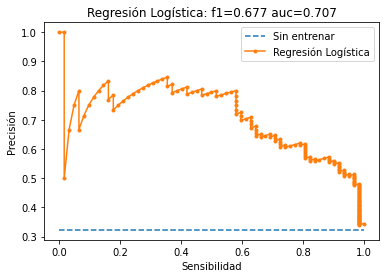

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Estrategia Oversampling en la clase minoritaria


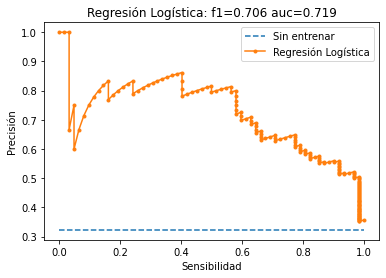

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Estrategia solo Parametros Modificados


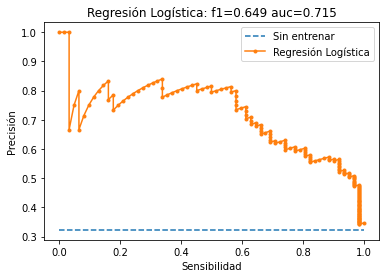

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Estrategia: Undersampling Aleatorio


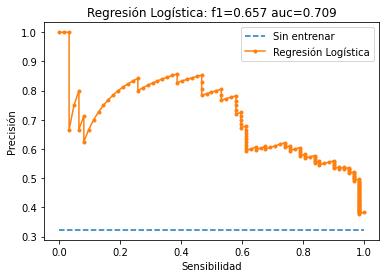

In [112]:
def Grafica_Recall_Precision(modelo,X_test,y_pred_prob,y_test):
    # Sacamos los valores
    yhat = modelo.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    # Resumimos 
    # trazar las curvas de recuperación de precisión
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
    #Etiquetas de ejes
    pyplot.xlabel('Sensibilidad')
    pyplot.ylabel('Precisión')
    pyplot.title('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    pyplot.legend()
    plt.savefig('recall1.eps',format='eps')
    pyplot.show()


print('Estrategia Penalización por Compensación')
Grafica_Recall_Precision(logreg_1,X_test,y_pred_prob_1,y_test)

print('\nEstrategia Oversampling en la clase minoritaria')
Grafica_Recall_Precision(modelo3,X_test,y_pred_prob_5,y_test)

print('\nEstrategia solo Parametros Modificados')
Grafica_Recall_Precision(logreg,X_test,y_pred_prob,y_test)

print('\nEstrategia: Undersampling Aleatorio')
Grafica_Recall_Precision(modelo2,X_test,y_pred_prob_4,y_test)